In [1]:
using DiffGP
using Flux
using Zygote
using PyPlot
using Random
using DelimitedFiles
using LinearAlgebra

Random.seed!(4);

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/hongbinren/.julia/packages/CUDAdrv/mCr0O/src/CUDAdrv.jl:69


In [2]:
# read CO2 data
data = readdlm("CO2_data.csv", ',')
year = data[:,1]; co2 = data[:,2];
# Split the data into training and testing data
xtrain = year[year.<2004]; ytrain = co2[year.<2004];
xtest = year[year.>=2004]; ytest = co2[year.>=2004];
Xtrain = reshape(xtrain, 1, length(xtrain));
Xtest = reshape(xtest, 1, length(xtest));

In [3]:
# use a composite kernel 
se1_kernel = IsoGaussKernel([exp(4.0)], [exp(4.0)])
per_kernel = IsoPeriodKernel([1.0], [1.0], [exp(1.0)])
se2_kernel = IsoGaussKernel([exp(4.0)], [1.0])
rq_kernel = IsoRQKernel([1.0], [exp(-1.0)], [1.0])
se3_kernel = IsoGaussKernel([exp(-2.0)], [exp(-2.0)])

se_per_kernel = SE_mul_PeriodKernel((se2_kernel, per_kernel))

kernel = AddCompositeKernel((se1_kernel, se_per_kernel, rq_kernel, se3_kernel))

# check PSD
@show isposdef(se_per_kernel(Xtrain))
@show isposdef(kernel(Xtrain))

isposdef(se_per_kernel(Xtrain)) = true
isposdef(kernel(Xtrain)) = true


true

In [4]:
# fit gp 
zero_mean = ConstantMean()
noise = [0.01]
gp = GaussProcess(zero_mean, kernel, noise)
ps = params(gp)
negloglik(gp, Xtrain, ytrain)
gs = gradient(()->negloglik(gp, Xtrain, ytrain), ps)
gs.grads

IdDict{Any,Any} with 14 entries:
  [1.0]      => [383.944]
  [1.0]      => [-31.9467]
  [1.0]      => [-31.8016]
  [2.71828]  => [5.85145]
  [1.0]      => [30.6979]
  [0.367879] => [0.119789]
  [0.135335] => [-58.7392]
  [0.135335] => [114.725]
  [0.0]      => [-0.190166]
  [0.01]     => [1143.98]
  [54.5982]  => [-0.218439]
  [54.5982]  => [0.016512]
  [54.5982]  => [-1.23575]
  [1.0]      => [15.8913]

In [5]:
ps

Params([[0.0], [54.598150033144236], [54.598150033144236], [54.598150033144236], [1.0], [1.0], [1.0], [2.718281828459045], [1.0], [0.36787944117144233], [1.0], [0.1353352832366127], [0.1353352832366127], [0.01]])

┌ Info: step=1, loss=238.5594013801064
└ @ Main In[6]:11
┌ Info: step=100, loss=211.82598040973926
└ @ Main In[6]:11
┌ Info: step=200, loss=206.8348200235988
└ @ Main In[6]:11
┌ Info: step=300, loss=204.92088839676546
└ @ Main In[6]:11
┌ Info: step=400, loss=204.28327464250543
└ @ Main In[6]:11
┌ Info: step=500, loss=203.955813662619
└ @ Main In[6]:11
┌ Info: step=600, loss=203.71501097199115
└ @ Main In[6]:11
┌ Info: step=700, loss=203.4885359128449
└ @ Main In[6]:11
┌ Info: step=800, loss=203.27110605971768
└ @ Main In[6]:11
┌ Info: step=900, loss=203.061147407249
└ @ Main In[6]:11


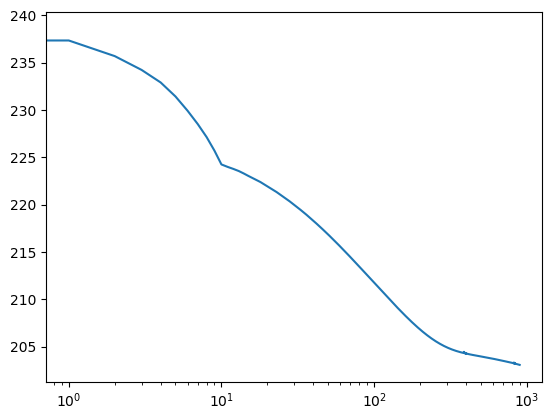

In [6]:
# minimize negative loglik

using Flux.Optimise: update!

optimizer = ADAM(0.001)
loss = []
for i in 1:900
    ll = negloglik(gp, Xtrain, ytrain)
    push!(loss, ll)
    if i==1 || i%100 == 0
        @info "step=$i, loss=$ll"
    end
    gs = gradient(()->negloglik(gp, Xtrain, ytrain), ps)
    for p in ps
        update!(optimizer, p, gs[p])
    end
end

plot(loss)
xscale("log")

In [7]:
ps = params(gp)

Params([[0.8947981026366698], [55.34101045299525], [55.489460595296435], [55.38821409003562], [0.7593243017922715], [0.9996368614518266], [1.3734727163257063], [2.486614689011516], [1.2651087274615134], [0.33641251690849217], [0.8179602255659033], [0.23390440233687274], [0.033298545309649034], [-0.009667531999801315]])

In [13]:
Year = reshape(year, 1, :)
pred_y, pred_σ2 = predict(gp, Year, Xtrain, ytrain);

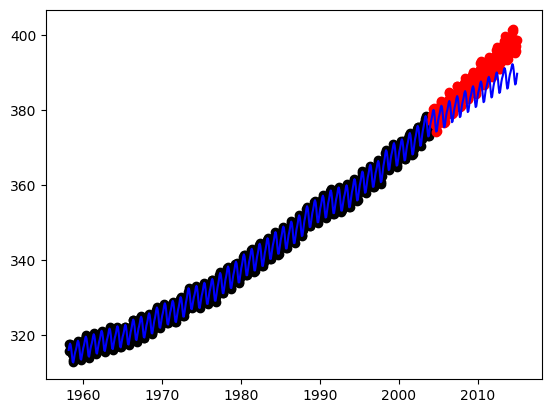

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x154181400>

In [14]:
scatter(xtrain, ytrain, color="k")
scatter(xtest, ytest, color="r")
plot(year, pred_y, "b")